In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

In [91]:
class PolygonGrowth(object):
    
    def __init__(self, polygon):
        self.polygons = [polygon]
        self.growth = polygon
        self.growth = Polygon(self.growth.exterior)
        self.obj_func = None
        
    def _repr_svg_(self):
        return self.growth._repr_svg_()
        
    @property
    def lines(self):
        lss = []
        for p in self.polygons:
            b = p.boundary
            if b.type == 'LineString':
                lss.append(b)
            elif b.type == 'MultiLineString':
                lss += list(b)
        return MultiLineString(lss)
        
    def calc_polygon_diff(self, polygon):
        return polygon.difference(self.growth)
        
    def add_polygon_diff(self, polygon):
        polygon_diff = self.calc_polygon_diff(polygon)
        self.polygons.append(polygon_diff)
        self.growth = so.unary_union([self.growth, polygon_diff])
        self.growth = Polygon(self.growth.boundary)
        
    def get_boundary_point(self, boundary_loc=None):
        if boundary_loc is None:
            boundary_loc = np.random.rand()
        return self.growth.boundary.interpolate(boundary_loc, normalized=True)
    
    def get_random_boundary_points(self, n):
        return MultiPoint([self.get_boundary_point() for i in range(n)])
    
    def get_boundary_points(self, boundary_locs):
        return MultiPoint([self.get_boundary_point(b) for b in boundary_locs])
    
    def grow_random_circle_diff(self, rad):
        self.add_polygon_diff(self.get_boundary_point().buffer(rad))
        
    def buffer_growth(self, d):
        self.growth = self.growth.buffer(d)
        self.growth = Polygon(self.growth.exterior)
        
    def filter_points_by_distance(self, points, target_point, descending=True, n_filtered_points=1):
        dists = [target_point.distance(p) for p in points]
        if descending:
            ordered = np.argsort(dists)
        else:
            ordered = np.argsort(-dists)
        return MultiPoint([points[i] for i in ordered[:n_filtered_points]])
    
    def get_LineFactory(self):
        lf = LineFactory()
        for line in self.lines:
            lf.add_line(np.asarray(line.xy))
        return lf
    
    
class TargetPointGrowth(PolygonGrowth):
    
    def grow_circle_diff(self, target_point, rad, n_checks, **kwargs):
        points = self.get_random_boundary_points(n=n_checks)
        fps = self.filter_points_by_distance(points, target_point, **kwargs)
        for fp in fps:
            self.add_polygon_diff(fp.buffer(rad))
            
            

# nfl

In [3]:
df = pd.read_csv('/mnt/c/data/side/nfl_games.csv')

In [15]:
groups = df.groupby(['score_home', 'score_away'])

In [96]:
# make page
paper_size = '11x14 inches'
border:float=20
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [125]:
yard_scale = 0.0003
n_checks = 30

In [165]:
mlss = []
f = 0
for score, group in groups:
    ## initialize
    tp = Point(score)
    start_circle = tp.buffer(0.01)
    main_orb = TargetPointGrowth(start_circle)
#     main_orb.buffer_growth(0.1)
    for i, row in group.iterrows():
        try:
            total_yards = row['yards_home'] + row['yards_away']
            rad = total_yards * yard_scale
            main_orb.grow_circle_diff(target_point=tp, rad=rad, n_checks=n_checks)
            main_orb.buffer_growth(0.3)
        except:
            f+=1
    polys = gp.merge_Polygons(main_orb.polygons[1:])
    mlss.append(polys)

In [167]:
all_mlss = gp.make_like(gp.merge_Polygons(mlss), drawbox)

In [160]:
buffs = gp.merge_Polygons([p.buffer(0.1) for p in all_mlss])

In [136]:
bb = all_mlss.boundary.buffer(0.1, cap_style=2, join_style=2)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.1mm')
sk.geometry(all_mlss.buffer(0.1).boundary)

# tolerance=0.5
# sk.vpype(f'linemerge --tolerance {tolerance}mm linesort')

sk.display()

In [140]:
pts = MultiPoint([Point(score) for score, group in groups])

In [151]:
tris = gp.make_like(gp.merge_Polygons(so.triangulate(pts)), drawbox)

In [154]:
tribs = tris.buffer(-0.2).boundary

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.1mm')
sk.geometry(tribs)

sk.display()

In [151]:
target_point = drawbox.centroid
max_rads = [40, ]
min_rads = [1,]
circles_per_wave = [100, ]
check_ns_per_wave = [ 250, ]
tps = [target_point ]

rads = []
check_ns = []

for max_rad, min_rad, n_circles, check_n in zip(max_rads, min_rads, circles_per_wave, check_ns_per_wave):
    rads.append(np.logspace(np.log10(max_rad), np.log10(min_rad), int(n_circles)))
    check_ns.append(np.repeat(check_n, n_circles))


target_points = []
for tp, n_circles_per_wave in zip(tps, circles_per_wave):
    target_points += [tp] * n_circles_per_wave

rads = np.concatenate(rads)
check_ns = np.concatenate(check_ns)
init_rad = rads[0]

NameError: name 'score' is not defined

In [153]:
for i, rad in enumerate(tqdm(rads)):
    n_checks = check_ns[i]
    target_point = target_points[i]
    try:
        main_orb.grow_circle_diff(target_point=target_point, rad=rad, n_checks=n_checks)
    except:
        pass


100%|██████████| 100/100 [00:01<00:00, 91.99it/s]


# photos

In [27]:
from skimage import exposure

from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk

In [48]:
img

array([[[250, 250, 250],
        [252, 252, 252],
        [253, 253, 253],
        ...,
        [249, 249, 248],
        [247, 247, 246],
        [248, 249, 245]],

       [[250, 250, 250],
        [251, 251, 251],
        [252, 252, 252],
        ...,
        [248, 246, 243],
        [246, 245, 242],
        [248, 247, 244]],

       [[251, 251, 251],
        [251, 251, 251],
        [253, 253, 253],
        ...,
        [248, 247, 245],
        [249, 248, 246],
        [253, 249, 248]],

       ...,

       [[255,   8,  11],
        [254,   7,  12],
        [246, 255,   4],
        ...,
        [  7,   5,   5],
        [  5,   2,   5],
        [  2, 255,   0]],

       [[252,   5,   8],
        [247,   0,   3],
        [241, 248, 253],
        ...,
        [253, 252, 255],
        [255, 254,   1],
        [  2,   1,   4]],

       [[253,   4,   7],
        [245, 252, 255],
        [234, 241, 246],
        ...,
        [253, 254,   2],
        [255,   0,   4],
        [  3,   4,   8]]

In [50]:
image_path = '/mnt/c/Users/alex/Pictures/Camera Roll/1-11-2021/DSC04194.JPG'
img0 = rgb2gray(io.imread(image_path))

image_path = '/mnt/c/Users/alex/Pictures/Camera Roll/1-11-2021/DSC04196.JPG'
img1 = rgb2gray(io.imread(image_path))

img = img1 - img0

# img = rescale(img, 0.06)

# x, y = np.mgrid[-10:10:255j, -10:10:255j]
# img = np.sin(x ** 2 + y ** 2)

In [62]:
cimg = img[:3000, :4000]

In [66]:
def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

In [67]:
selem = disk(2)
filt_img = filters.rank.mean(cimg, selem)
angle_farid = local_angle(filters.farid_h(filt_img), filters.farid_v(filt_img))

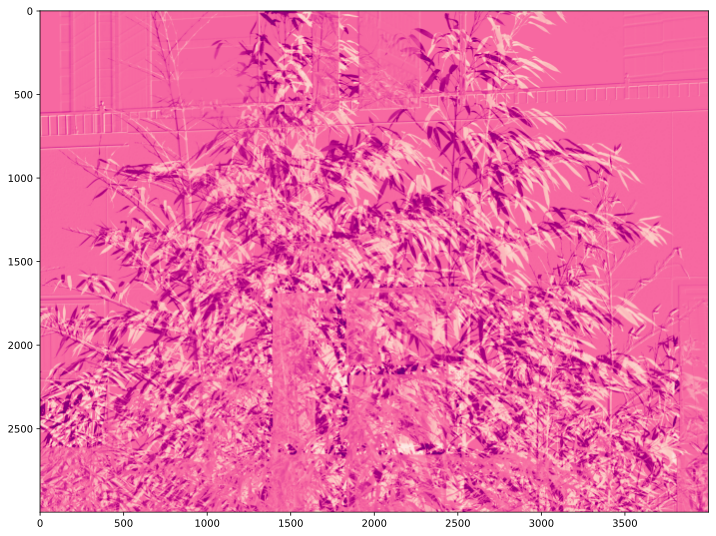

In [171]:
f, ax = plt.subplots(figsize=(12,10))
ax.imshow(cimg, cmap = 'RdPu', )

In [46]:
io.imsave('/mnt/c/data/side/tree_wind_difference_ds.jpeg', img)